In [21]:
# Hocine KADEM 21309534
# Neil BENAHMED 21200977

### Dans ce notebook, nous allons tester les wrappers d'observations et d'action voir leur impacte, et explorer les differents paramétres, sachant qu'en enlevant les features thetha et x', les algorithmes n'arrive pas trés bien a trouvé une bonne politique, voyons voir les differences notables en appliquant les 2 derniers wrappers.

In [22]:
%load_ext autoreload
%autoreload 2
# Prepare the environment
try:
    from easypip import easyimport
except ModuleNotFoundError:
    from subprocess import run

    assert (
        run(["pip", "install", "easypip"]).returncode == 0
    ), "Could not install easypip"
    from easypip import easyimport

easyimport("swig")
easyimport("bbrl_utils").setup(maze_mdp=False)

import os
import copy
import numpy as np
import gymnasium as gym
import math
import bbrl_gymnasium  # noqa: F401
import torch
import torch.nn as nn
from bbrl.agents import Agent, Agents, TemporalAgent
from bbrl_utils.algorithms import EpochBasedAlgo
from bbrl_utils.nn import build_mlp, setup_optimizer, soft_update_params
from bbrl_utils.notebook import setup_tensorboard
from bbrl.visu.plot_policies import plot_policy
from omegaconf import OmegaConf
from td3_ddpg import DDPG, run_ddpg, TD3, run_td3
import utils
import matplotlib.pyplot as plt
from wrappers import FeatureFilterWrapper, ObsTimeExtensionWrapper, ActionTimeExtensionWrapper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
params = {
    "save_best": False,
    "base_dir": "${gym_env.env_name}/ddpg-S${algorithm.seed}_${current_time:}",
    "collect_stats": True,
    # Set to true to have an insight on the learned policy
    # (but slows down the evaluation a lot!)
    "plot_agents": True,
    "algorithm": {
        "seed": 1,
        "max_grad_norm": 0.5,
        "epsilon": 0.02,
        "n_envs": 1,
        "n_steps": 100,
        "nb_evals": 10,
        "discount_factor": 0.8,
        "buffer_size": 1e6,
        "batch_size": 64,
        "tau_target": 0.05,
        "eval_interval": 2_000,
        "max_epochs": 6000,
        # Minimum number of transitions before learning starts
        "learning_starts": 10_000,
        "action_noise": 0.1,
        "architecture": {
            "actor_hidden_size": [400, 300],
            "critic_hidden_size": [400, 300],
        },
    },
    "gym_env": {
        "env_name": "CartPoleContinuous-v1",
    },
    "actor_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
        # "eps": 5e-5,
    },
    "critic_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
        # "eps": 5e-5,
    },
}

# TESTS

Definitions des fonctions utiles pour les executer les wrappers 

In [33]:
def feature_filter_wrapper_1(env):
    """Wrapper pour enlever la première feature (par exemple, l'index 1)"""
    return FeatureFilterWrapper(env, 1)

def feature_filter_wrapper_3(env):
    """Wrapper pour enlever la troisième feature (par exemple, l'index 3)"""
    return FeatureFilterWrapper(env, 3)

def feature_filter_wrapper_both(env):
    """Wrapper pour enlever les deux features : première et troisième"""
    return FeatureFilterWrapper(FeatureFilterWrapper(env, 3), 1)

memory_size=3
action_repeat=3

def obs_time_extension_wrapper_dx(env):
    """Appliquer ObsTimeExtensionWrapper avec mémoire et enlever la première feature."""
    return ObsTimeExtensionWrapper(feature_filter_wrapper_1(env), memory_size)

def obs_time_extension_wrapper_dtheta(env):
    """Appliquer ObsTimeExtensionWrapper avec mémoire et enlever la troisième feature."""
    return ObsTimeExtensionWrapper(feature_filter_wrapper_3(env), memory_size)

def obs_time_extension_wrapper_both(env):
    """Appliquer ObsTimeExtensionWrapper avec mémoire et enlever les deux features."""
    return ObsTimeExtensionWrapper(feature_filter_wrapper_both(env), memory_size)


def action_time_extension_wrapper_dx(env):
    """Appliquer ActionTimeExtensionWrapper avec répétition d'actions et enlever la première feature."""
    return ActionTimeExtensionWrapper(feature_filter_wrapper_1(env), action_repeat)

def action_time_extension_wrapper_dtheta(env):
    """Appliquer ActionTimeExtensionWrapper avec répétition d'actions et enlever la troisième feature."""
    return ActionTimeExtensionWrapper(feature_filter_wrapper_3(env), action_repeat)

def action_time_extension_wrapper_both(env):
    """Appliquer ActionTimeExtensionWrapper avec répétition d'actions et enlever les deux features."""
    return ActionTimeExtensionWrapper(feature_filter_wrapper_both(env), action_repeat)


def full_extension_wrapper_dx(env):
    """Appliquer ObsTimeExtensionWrapper, ActionTimeExtensionWrapper avec mémoire et actions répétées, et enlever la première feature."""
    return ObsTimeExtensionWrapper(ActionTimeExtensionWrapper(feature_filter_wrapper_1(env), action_repeat), memory_size)

def full_extension_wrapper_dtheta(env):
    """Appliquer ObsTimeExtensionWrapper, ActionTimeExtensionWrapper avec mémoire et actions répétées, et enlever la troisième feature."""
    return ObsTimeExtensionWrapper(ActionTimeExtensionWrapper(feature_filter_wrapper_3(env), action_repeat), memory_size)

def full_extension_wrapper_both(env):
    """Appliquer ObsTimeExtensionWrapper, ActionTimeExtensionWrapper avec mémoire et actions répétées, et enlever les deux features."""
    return ObsTimeExtensionWrapper(ActionTimeExtensionWrapper(feature_filter_wrapper_both(env), action_repeat), memory_size)

### Fonction pour lancer les tests sur OBS

In [35]:
import os
import matplotlib.pyplot as plt

def test_memory_sizes_ddpg_td3(memory_sizes, params):
    """
    Teste différentes valeurs de memory_size pour le wrapper d'observation avec DDPG et TD3,
    enregistre les résultats dans des fichiers et stocke chaque instance de DDPG et TD3 dans un dictionnaire.

    Args:
        memory_sizes (list): Liste des tailles de mémoire à tester.
        params (dict): Paramètres généraux pour les algorithmes DDPG et TD3.

    Returns:
        dict: Dictionnaire contenant les instances de DDPG et TD3.
    """
    ddpg_instances = {}
    td3_instances = {}
    fonction_wrappers_ici = feature_filter_wrapper_both

    # Créer le dossier 'saves' s'il n'existe pas
    if not os.path.exists('saves'):
        os.makedirs('saves')

    for memory_size_value in memory_sizes:
        # Redéfinir memory_size pour chaque itération
        global memory_size
        memory_size = memory_size_value

        # Tester DDPG avec différentes valeurs de memory_size
        print(f"Testing DDPG with memory_size={memory_size_value}")
        ddpg_instance = DDPG(OmegaConf.create(params), [obs_time_extension_wrapper_both])
        critic_losses_ddpg, actor_losses_ddpg, rewards_per_step_ddpg, steps_ddpg, best_rewards_ddpg, running_rewards_ddpg = run_ddpg(ddpg_instance)
        
        # Stocker l'instance de DDPG
        ddpg_instances[memory_size_value] = ddpg_instance
        
        # Tracer et sauvegarder les résultats pour DDPG
        plot_filename_ddpg = f"saves/ddpg_memory_size_{memory_size_value}.png"
        plot_metrics_and_save(critic_losses_ddpg, actor_losses_ddpg, running_rewards_ddpg, plot_filename_ddpg, f"DDPG with memory_size={memory_size_value}")
        print(f"DDPG results saved to {plot_filename_ddpg}")
        
        # Tester TD3 avec différentes valeurs de memory_size
        print(f"Testing TD3 with memory_size={memory_size_value}")
        td3_instance = TD3(OmegaConf.create(params), [obs_time_extension_wrapper_both])
        critic_losses_td3, actor_losses_td3, rewards_per_step_td3, steps_td3, best_rewards_td3, running_rewards_td3 = run_td3(td3_instance)
        
        # Stocker l'instance de TD3
        td3_instances[memory_size_value] = td3_instance
        
        # Tracer et sauvegarder les résultats pour TD3
        plot_filename_td3 = f"saves/td3_memory_size_{memory_size_value}.png"
        plot_metrics_and_save(critic_losses_td3, actor_losses_td3, running_rewards_td3, plot_filename_td3, f"TD3 with memory_size={memory_size_value}")
        print(f"TD3 results saved to {plot_filename_td3}")
    
    # Retourner les dictionnaires d'instances de DDPG et TD3
    return {'ddpg_instances': ddpg_instances, 'td3_instances': td3_instances}


def plot_metrics_and_save(critic_losses, actor_losses, running_rewards, filename, title):
    """
    Trace les metrics et enregistre le plot dans un fichier avec un titre principal.

    Args:
        critic_losses (list or tensor): Liste ou tenseur des pertes du critic.
        actor_losses (list or tensor): Liste ou tenseur des pertes de l'acteur.
        running_rewards (list or tensor): Liste ou tenseur des running rewards.
        filename (str): Nom du fichier où enregistrer le plot.
        title (str): Titre principal pour le plot.

    Returns:
        None
    """
    plt.figure(figsize=(7, 8))
    
    # Plot Critic Loss
    plt.subplot(3, 1, 1)
    plt.plot(critic_losses, label="Critic Loss", color='blue')
    plt.xlabel("Episodes")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
    # Plot Actor Loss
    plt.subplot(3, 1, 2)
    plt.plot(actor_losses, label="Actor Loss", color='green')
    plt.xlabel("Episodes")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
    # Plot Running Rewards
    plt.subplot(3, 1, 3)
    plt.plot(running_rewards, label="Running Rewards", color='orange')
    plt.xlabel("Episodes")
    plt.ylabel("Running Rewards")
    plt.legend()
    plt.grid(True)
    
    # Ajouter le titre principal en haut
    plt.suptitle(title, fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Pour éviter que le titre chevauche les subplots

    # Sauvegarder le plot dans un fichier
    plt.savefig(filename)
    plt.close()


In [36]:
# Liste des tailles de mémoire à tester
memory_sizes = [3, 5, 8, 10, 50]

# Appel pour tester les différentes valeurs de memory_size avec DDPG et TD3
results = test_memory_sizes_ddpg_td3(memory_sizes, params)

Testing DDPG with memory_size=3


  0%|          | 0/6000 [00:00<?, ?it/s]

DDPG results saved to saves/ddpg_memory_size_3.png
Testing TD3 with memory_size=3


  0%|          | 0/6000 [00:00<?, ?it/s]

TD3 results saved to saves/td3_memory_size_3.png
Testing DDPG with memory_size=5


  0%|          | 0/6000 [00:00<?, ?it/s]

DDPG results saved to saves/ddpg_memory_size_5.png
Testing TD3 with memory_size=5


  0%|          | 0/6000 [00:00<?, ?it/s]

TD3 results saved to saves/td3_memory_size_5.png
Testing DDPG with memory_size=8


  0%|          | 0/6000 [00:00<?, ?it/s]

DDPG results saved to saves/ddpg_memory_size_8.png
Testing TD3 with memory_size=8


  0%|          | 0/6000 [00:00<?, ?it/s]

TD3 results saved to saves/td3_memory_size_8.png
Testing DDPG with memory_size=10


  0%|          | 0/6000 [00:00<?, ?it/s]

DDPG results saved to saves/ddpg_memory_size_10.png
Testing TD3 with memory_size=10


  0%|          | 0/6000 [00:00<?, ?it/s]

TD3 results saved to saves/td3_memory_size_10.png
Testing DDPG with memory_size=50


  0%|          | 0/6000 [00:00<?, ?it/s]

DDPG results saved to saves/ddpg_memory_size_50.png
Testing TD3 with memory_size=50


  0%|          | 0/6000 [00:00<?, ?it/s]

TD3 results saved to saves/td3_memory_size_50.png


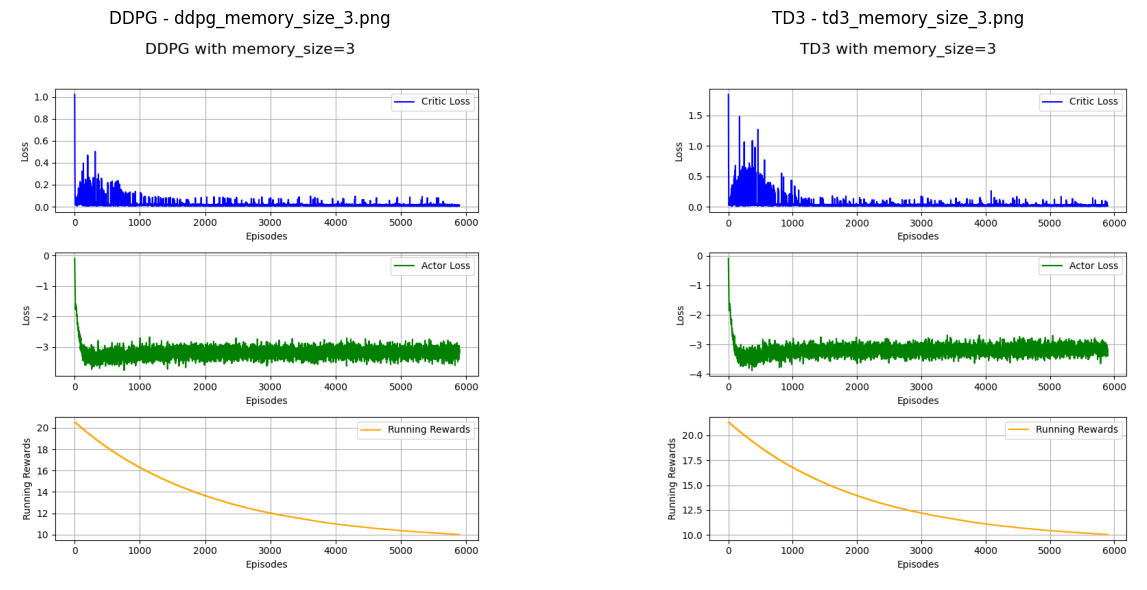

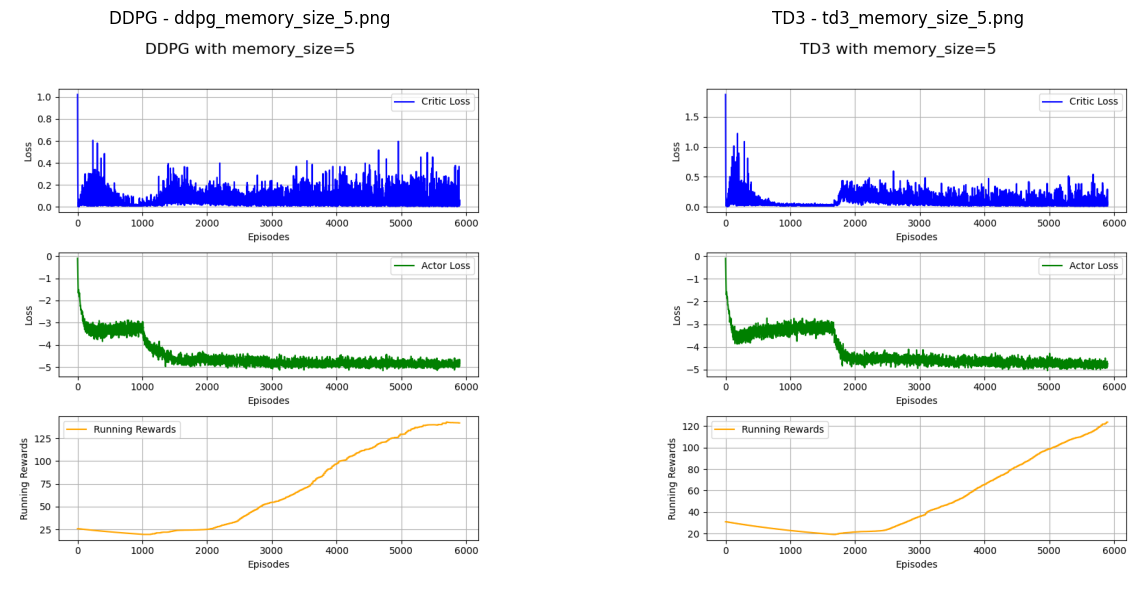

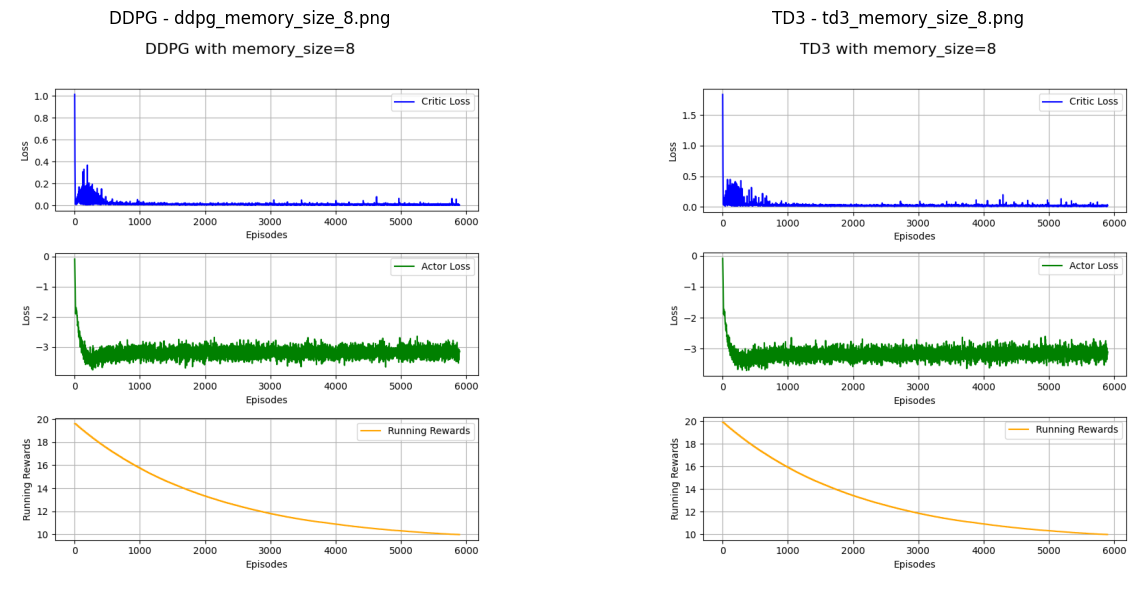

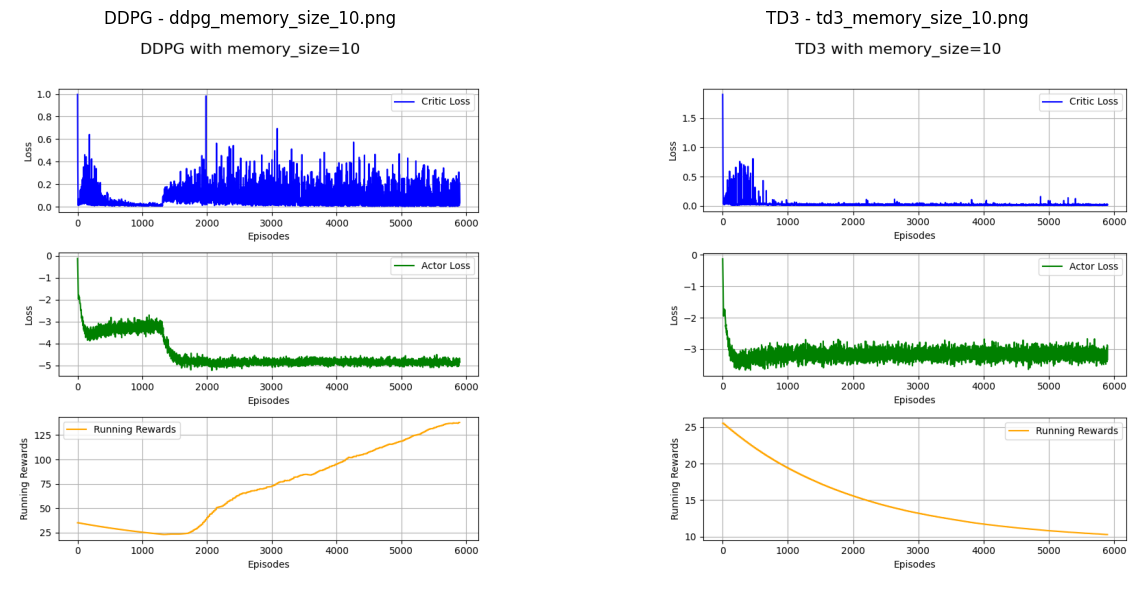

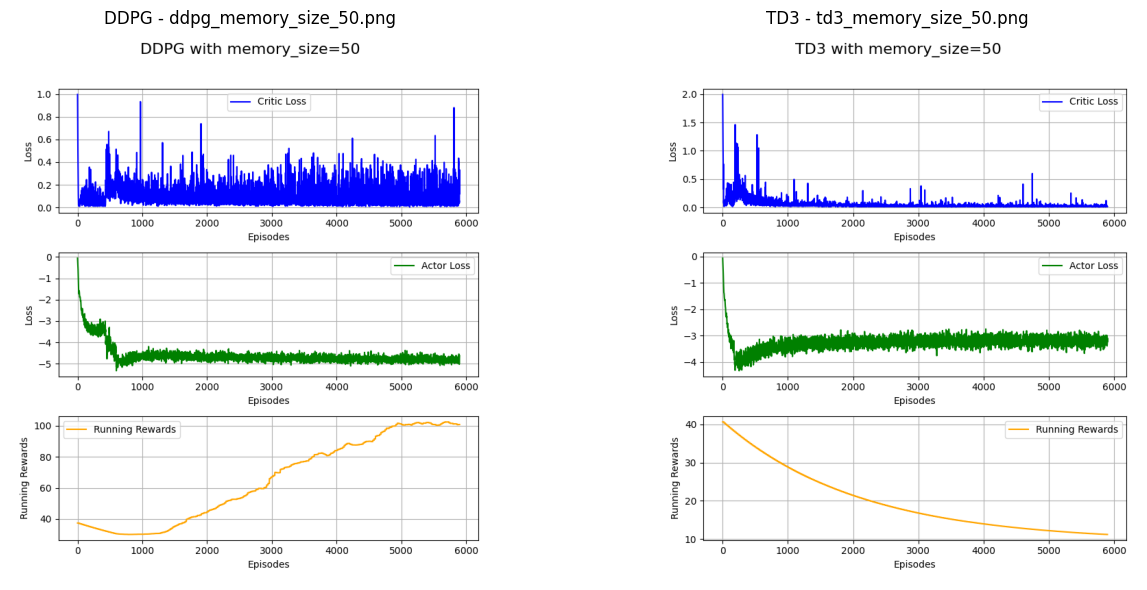

In [41]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import re

def extract_memory_size(file_name):
    """
    Extrait la valeur de 'memory_size' du nom de fichier.
    
    Args:
        file_name (str): Le nom du fichier à analyser.
    
    Returns:
        int: La valeur de 'memory_size' si elle est trouvée, sinon 0.
    """
    match = re.search(r'memory_size_(\d+)', file_name)
    return int(match.group(1)) if match else 0

def plot_all_obs_graphs():
    """
    Affiche les graphiques liés à ObsTimeExtensionWrapper à partir des fichiers enregistrés dans le dossier 'saves'.
    Les graphiques sont affichés par binôme (DDPG et TD3) pour chaque memory_size, côte à côte.
    """
    # Dossier contenant les fichiers de sauvegarde
    save_folder = "saves"
    
    # Vérifier si le dossier existe
    if not os.path.exists(save_folder):
        print(f"Le dossier '{save_folder}' n'existe pas.")
        return

    # Filtrer et trier les fichiers correspondant aux résultats de 'ObsTimeExtensionWrapper'
    ddpg_files = sorted(
        [f for f in os.listdir(save_folder) if "ddpg_memory_size" in f and f.endswith(".png")],
        key=extract_memory_size
    )
    td3_files = sorted(
        [f for f in os.listdir(save_folder) if "td3_memory_size" in f and f.endswith(".png")],
        key=extract_memory_size
    )
    
    # S'assurer que nous avons des binômes correspondants
    if not ddpg_files or not td3_files:
        print("Aucun fichier correspondant trouvé pour DDPG ou TD3.")
        return

    # Vérifier que les deux listes ont le même nombre d'éléments
    if len(ddpg_files) != len(td3_files):
        print("Le nombre de fichiers DDPG et TD3 ne correspond pas.")
        return

    # Afficher les plots par binôme (DDPG et TD3 côte à côte)
    for ddpg_file, td3_file in zip(ddpg_files, td3_files):
        ddpg_path = os.path.join(save_folder, ddpg_file)
        td3_path = os.path.join(save_folder, td3_file)

        # Ouvrir les images DDPG et TD3
        ddpg_image = Image.open(ddpg_path)
        td3_image = Image.open(td3_path)

        # Afficher les deux images côte à côte
        plt.figure(figsize=(14, 6))  # Augmenter la taille des figures

        # Sous-plot 1 : DDPG
        plt.subplot(1, 2, 1)
        plt.imshow(ddpg_image)
        plt.axis('off')
        plt.title(f"DDPG - {ddpg_file}")

        # Sous-plot 2 : TD3
        plt.subplot(1, 2, 2)
        plt.imshow(td3_image)
        plt.axis('off')
        plt.title(f"TD3 - {td3_file}")

        # Afficher les figures
        plt.tight_layout()
        plt.show()

# Appel de la fonction pour afficher tous les graphiques DDPG et TD3 côte à côte
plot_all_obs_graphs()


In [42]:
import os
import matplotlib.pyplot as plt

def test_action_extension_wrapper(action_repeat_values, params):
    """
    Teste différentes valeurs de action_repeat pour le wrapper d'action avec DDPG et TD3,
    enregistre les résultats dans des fichiers et stocke chaque instance de DDPG et TD3 dans un dictionnaire.

    Args:
        action_repeat_values (list): Liste des valeurs de répétition d'actions à tester.
        params (dict): Paramètres généraux pour les algorithmes DDPG et TD3.

    Returns:
        dict: Dictionnaire contenant les instances de DDPG et TD3.
    """
    ddpg_instances = {}
    td3_instances = {}
    fonction_wrappers_ici = feature_filter_wrapper_both

    # Créer le dossier 'saves' s'il n'existe pas
    if not os.path.exists('saves'):
        os.makedirs('saves')

    for action_repeat_value in action_repeat_values:
        # Redéfinir action_repeat pour chaque itération
        global action_repeat
        action_repeat = action_repeat_value

        # Tester DDPG avec différentes valeurs de action_repeat
        print(f"Testing DDPG with action_repeat={action_repeat_value}")
        ddpg_instance = DDPG(OmegaConf.create(params), [action_time_extension_wrapper_both])
        critic_losses_ddpg, actor_losses_ddpg, rewards_per_step_ddpg, steps_ddpg, best_rewards_ddpg, running_rewards_ddpg = run_ddpg(ddpg_instance)
        
        # Stocker l'instance de DDPG
        ddpg_instances[action_repeat_value] = ddpg_instance
        
        # Tracer et sauvegarder les résultats pour DDPG
        plot_filename_ddpg = f"saves/ddpg_action_repeat_{action_repeat_value}.png"
        plot_metrics_and_save(critic_losses_ddpg, actor_losses_ddpg, running_rewards_ddpg, plot_filename_ddpg, f"DDPG with action_repeat={action_repeat_value}")
        print(f"DDPG results saved to {plot_filename_ddpg}")
        
        # Tester TD3 avec différentes valeurs de action_repeat
        print(f"Testing TD3 with action_repeat={action_repeat_value}")
        td3_instance = TD3(OmegaConf.create(params), [action_time_extension_wrapper_both])
        critic_losses_td3, actor_losses_td3, rewards_per_step_td3, steps_td3, best_rewards_td3, running_rewards_td3 = run_td3(td3_instance)
        
        # Stocker l'instance de TD3
        td3_instances[action_repeat_value] = td3_instance
        
        # Tracer et sauvegarder les résultats pour TD3
        plot_filename_td3 = f"saves/td3_action_repeat_{action_repeat_value}.png"
        plot_metrics_and_save(critic_losses_td3, actor_losses_td3, running_rewards_td3, plot_filename_td3, f"TD3 with action_repeat={action_repeat_value}")
        print(f"TD3 results saved to {plot_filename_td3}")
    
    # Retourner les dictionnaires d'instances de DDPG et TD3
    return {'ddpg_instances': ddpg_instances, 'td3_instances': td3_instances}


def plot_metrics_and_save(critic_losses, actor_losses, running_rewards, filename, title):
    """
    Trace les metrics et enregistre le plot dans un fichier avec un titre principal.

    Args:
        critic_losses (list or tensor): Liste ou tenseur des pertes du critic.
        actor_losses (list or tensor): Liste ou tenseur des pertes de l'acteur.
        running_rewards (list or tensor): Liste ou tenseur des running rewards.
        filename (str): Nom du fichier où enregistrer le plot.
        title (str): Titre principal pour le plot.

    Returns:
        None
    """
    plt.figure(figsize=(7, 8))
    
    # Plot Critic Loss
    plt.subplot(3, 1, 1)
    plt.plot(critic_losses, label="Critic Loss", color='blue')
    plt.xlabel("Episodes")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
    # Plot Actor Loss
    plt.subplot(3, 1, 2)
    plt.plot(actor_losses, label="Actor Loss", color='green')
    plt.xlabel("Episodes")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
    # Plot Running Rewards
    plt.subplot(3, 1, 3)
    plt.plot(running_rewards, label="Running Rewards", color='orange')
    plt.xlabel("Episodes")
    plt.ylabel("Running Rewards")
    plt.legend()
    plt.grid(True)
    
    # Ajouter le titre principal en haut
    plt.suptitle(title, fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Pour éviter que le titre chevauche les subplots

    # Sauvegarder le plot dans un fichier
    plt.savefig(filename)
    plt.close()


In [43]:
# Liste des valeurs de répétition d'action à tester
action_repeat_values = [2, 5, 8, 30]


# Appel pour tester les différentes valeurs de action_repeat avec DDPG et TD3
results_action = test_action_extension_wrapper(action_repeat_values, params)


Testing DDPG with action_repeat=2


  0%|          | 0/6000 [00:00<?, ?it/s]

DDPG results saved to saves/ddpg_action_repeat_2.png
Testing TD3 with action_repeat=2


  0%|          | 0/6000 [00:00<?, ?it/s]

TD3 results saved to saves/td3_action_repeat_2.png
Testing DDPG with action_repeat=5


  0%|          | 0/6000 [00:00<?, ?it/s]

DDPG results saved to saves/ddpg_action_repeat_5.png
Testing TD3 with action_repeat=5


  0%|          | 0/6000 [00:00<?, ?it/s]

TD3 results saved to saves/td3_action_repeat_5.png
Testing DDPG with action_repeat=8


  0%|          | 0/6000 [00:00<?, ?it/s]

DDPG results saved to saves/ddpg_action_repeat_8.png
Testing TD3 with action_repeat=8


  0%|          | 0/6000 [00:00<?, ?it/s]

TD3 results saved to saves/td3_action_repeat_8.png
Testing DDPG with action_repeat=30


  0%|          | 0/6000 [00:00<?, ?it/s]

DDPG results saved to saves/ddpg_action_repeat_30.png
Testing TD3 with action_repeat=30


  0%|          | 0/6000 [00:00<?, ?it/s]

TD3 results saved to saves/td3_action_repeat_30.png
